<a href="https://colab.research.google.com/github/chemaoxfz/bi23/blob/main/202204_FBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf')
sns.set(style='ticks', palette=colors)

sns.set_context('talk',font_scale=2,rc={'lines.linewidth':3})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


In [ ]:
!pip install cobra

In [ ]:
import cobra.test

In [ ]:
model = cobra.test.create_test_model('ecoli')
model

Name,iJO1366
Memory address,0x07f3af8349990
Number of metabolites,1805
Number of reactions,2583
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [ ]:
model = cobra.test.create_test_model('textbook')
model

Name,e_coli_core
Memory address,0x07f3af6900a50
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [ ]:
model.reactions.get_by_id('ATPM')

Reaction identifier,ATPM
Name,ATP maintenance requirement
Memory address,0x07f3af683a5d0
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c ATP + H2O --> ADP + H+ + Phosphate
GPR,
Lower bound,8.39
Upper bound,1000.0


In [ ]:
model.metabolites.get_by_id('atp_c')

Metabolite identifier,atp_c
Name,ATP
Memory address,0x07f3afbdf6810
Formula,C10H12N5O13P3
Compartment,c
In 13 reaction(s),"ATPM, PPS, PFK, SUCOAS, ADK1, ATPS4r, GLNabc, Biomass_Ecoli_core, ACKr, PGK, PYK, GLNS, PPCK"


### Default objective is to maximize biomass production.

In [ ]:
print(model.objective.expression)
print(model.objective.direction)

1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
max


In [ ]:
model.reactions.get_by_id("Biomass_Ecoli_core")

Reaction identifier,Biomass_Ecoli_core
Name,Biomass Objective Function with GAM
Memory address,0x07f3afba9ab50
Stoichiometry,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c... 1.496 3-Phospho-D-glycerate + 3.7478 Acetyl-CoA + 59.81 ATP + 0.361 D-Erythrose 4-phosphate + 0.0709 D-Fructose 6-phosphate + 0.129 Glyceraldehyde 3-phosphate + 0.205 D-Glucose 6-phosphate + 0.2557...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [ ]:
model.reactions.get_by_id('EX_glc__D_e')

Reaction identifier,EX_glc__D_e
Name,D-Glucose exchange
Memory address,0x07f3afb9d9450
Stoichiometry,glc__D_e <=> D-Glucose <=>
GPR,
Lower bound,-10.0
Upper bound,1000.0


In [ ]:
model.reactions.get_by_id('EX_glc__D_e').lower_bound=-18.5

In [ ]:
solution = model.optimize()
solution.objective_value ## the unit for growth is per hour.

1.653071851156823

In [ ]:
model.summary() # This is growth under carbon-limited aerobic conditions. We see oxygen uptake.

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,18.5,6,100.00%
nh4_e,EX_nh4_e,9.014,0,0.00%
o2_e,EX_o2_e,38.74,0,0.00%
pi_e,EX_pi_e,6.081,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-40.65,1,100.00%
h2o_e,EX_h2o_e,-52.69,0,0.00%
h_e,EX_h_e,-33.16,0,0.00%


In [ ]:
model.metabolites.nadh_c.summary()

Percent,Flux,Reaction,Definition
12.46%,8.582,AKGDH,akg_c + coa_c + nad_c --> co2_c + nadh_c + succoa_c
8.51%,5.863,Biomass_Ecoli_core,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
42.54%,29.31,GAPD,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
12.46%,8.582,MDH,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
24.04%,16.56,PDH,coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
Percent,Flux,Reaction,Definition
100.00%,-68.9,NADH16,4.0 h_c + nadh_c + q8_c --> 3.0 h_e + nad_c + q8h2_c


In [ ]:
model.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
66.48%,80.61,ATPS4r,adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
24.18%,29.31,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
2.26%,2.744,PYK,adp_c + h_c + pep_c --> atp_c + pyr_c
7.08%,8.582,SUCOAS,atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c
Percent,Flux,Reaction,Definition
6.92%,-8.39,ATPM,atp_c + h2o_c --> adp_c + h_c + pi_c
81.55%,-98.87,Biomass_Ecoli_core,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
0.35%,-0.4227,GLNS,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
11.19%,-13.56,PFK,atp_c + f6p_c --> adp_c + fdp_c + h_c


### Anaerobic condition.

In [ ]:
model.reactions.get_by_id('EX_o2_e').lower_bound=-0 #no oxygen uptake allowed

In [ ]:
solution = model.optimize()
solution.objective_value # growth is now much lower.

0.47056517108867685

In [ ]:
model.summary() # This is growth under anaerobic condition. Secretion is different.

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.8408,1,0.75%
glc__D_e,EX_glc__D_e,18.5,6,99.25%
h2o_e,EX_h2o_e,12.09,0,0.00%
nh4_e,EX_nh4_e,2.566,0,0.00%
pi_e,EX_pi_e,1.731,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-15.17,2,33.05%
etoh_e,EX_etoh_e,-14.67,2,31.97%
for_e,EX_for_e,-32.12,1,34.98%
h_e,EX_h_e,-56.73,0,0.00%


## Growth on alternative substrates (succinate)

In [ ]:
model = cobra.test.create_test_model('textbook')
model.reactions.get_by_id('EX_glc__D_e').lower_bound=0
model.reactions.get_by_id('EX_succ_e').lower_bound=-20

In [ ]:
solution = model.optimize()
solution.objective_value

0.8401341768471446

In [ ]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
h_e,EX_h_e,23.15,0,0.00%
nh4_e,EX_nh4_e,4.581,0,0.00%
o2_e,EX_o2_e,33.28,0,0.00%
pi_e,EX_pi_e,3.091,0,0.00%
succ_e,EX_succ_e,20,4,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-44.25,1,100.00%
h2o_e,EX_h2o_e,-30.37,0,0.00%


Anaerobic is infeasible on succinate

In [ ]:
model.reactions.get_by_id('EX_o2_e').lower_bound=-0
solution = model.optimize()

/usr/local/lib/python3.7/dist-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [ ]:
model.reactions.get_by_id('ATPM') # ATP maintenance cannot be achieved in this situation

Reaction identifier,ATPM
Name,ATP maintenance requirement
Memory address,0x07f3af67b4e90
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c ATP + H2O --> ADP + H+ + Phosphate
GPR,
Lower bound,8.39
Upper bound,1000.0


### Objective as ATP optimization

In [ ]:
model = cobra.test.create_test_model('textbook')

# change the objective to ATPM
model.objective = "ATPM"

# The upper bound should be 1000, so that we get
# the actual optimal value
model.reactions.get_by_id("ATPM").upper_bound = 1000.

model.reactions.get_by_id('EX_glc__D_e').lower_bound=-1
model.reactions.get_by_id('EX_glc__D_e').upper_bound=-1

from cobra.util.solver import linear_reaction_coefficients
linear_reaction_coefficients(model)

{<Reaction ATPM at 0x7f3af51e1710>: 1.0}

In [ ]:
solution = model.optimize()
solution.objective_value # max production is 17.5 mol of ATP per mol of glucose

17.5

In [ ]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,1,6,100.00%
o2_e,EX_o2_e,6,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-6,1,100.00%
h2o_e,EX_h2o_e,-6,0,0.00%


## Robustness, or variation of growth rate for changing glucose uptake

In [ ]:
model = cobra.test.create_test_model('textbook')

In [ ]:
growth_rates = np.zeros((20,2));
npts=20
no2=2
glc_list=np.linspace(1,21,npts) #Vary glucose uptake from 0 to 20 mmol per gDW hour
o2_list=[17.5,10]

for j in range(no2):
  model.reactions.get_by_id('EX_o2_e').lower_bound=-o2_list[j]
  for i in range(npts):
    model.reactions.get_by_id('EX_glc__D_e').lower_bound=-glc_list[i]
    solution = model.optimize()
    growth_rates[i,j]=solution.objective_value


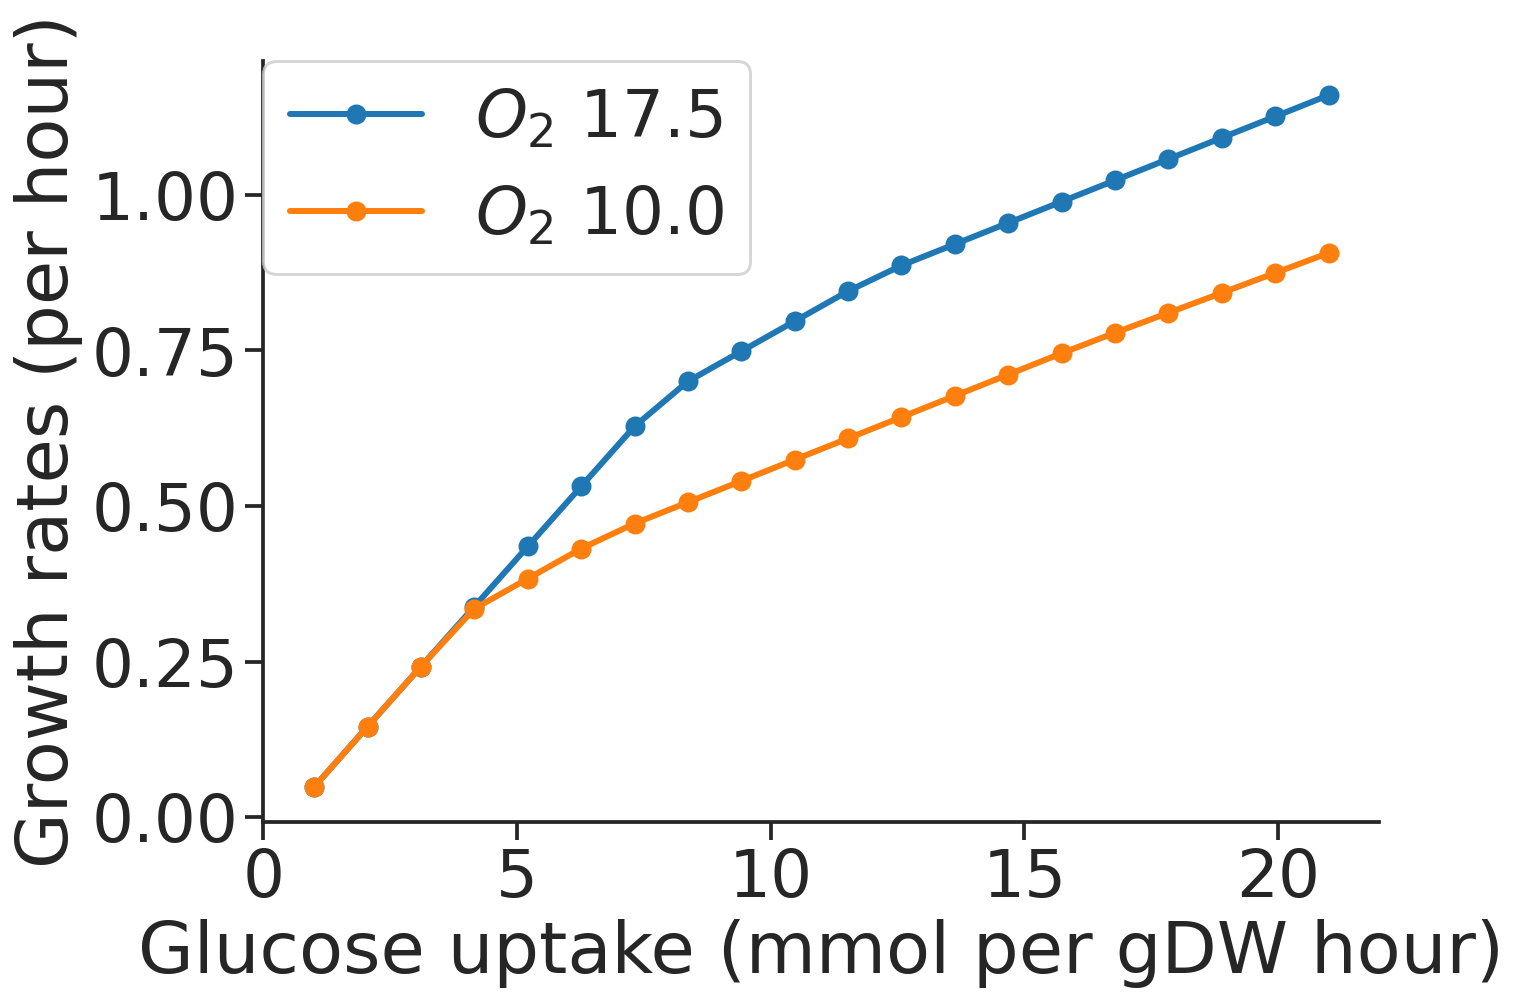

In [ ]:
sns.set_context('talk',font_scale=2,rc={'lines.linewidth':3})

fig, ax = plt.subplots(1, 1,figsize=(10,7))

ax.plot(glc_list,growth_rates[:,0],'-o',label=r'$O_2$ 17.5')
ax.plot(glc_list,growth_rates[:,1],'-o',label=r'$O_2$ 10.0')

ax.set_xlabel(r'Glucose uptake (mmol per gDW hour)')
ax.set_ylabel(r'Growth rates (per hour)')

#remove top and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', borderaxespad=0.0)


In [ ]:
npts=30
growth_rates = np.zeros(npts);
no2=2
o2_list=np.linspace(1,npts+1,npts) #Vary O2 uptake from 0 to 20 mmol per gDW hour
model.reactions.get_by_id('EX_glc__D_e').lower_bound=-10
for i in range(npts):
  model.reactions.get_by_id('EX_o2_e').lower_bound=-o2_list[i]
  solution = model.optimize()
  growth_rates[i]=solution.objective_value


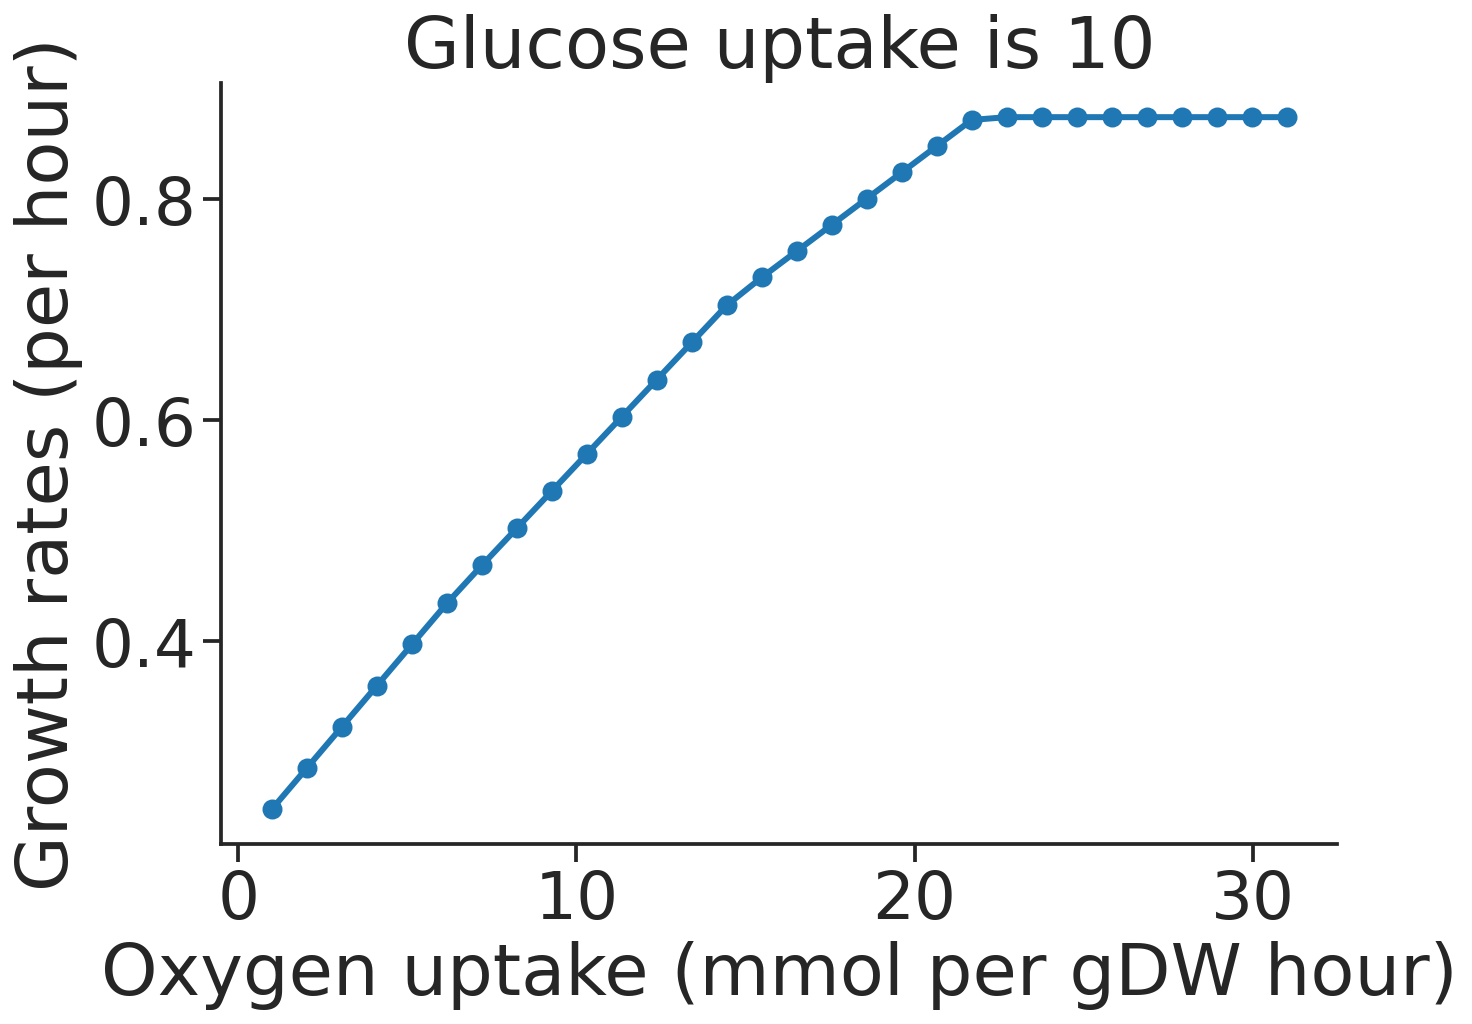

In [ ]:
sns.set_context('talk',font_scale=2,rc={'lines.linewidth':3})

fig, ax = plt.subplots(1, 1,figsize=(10,7))

ax.plot(o2_list,growth_rates,'-o')

ax.set_xlabel(r'Oxygen uptake (mmol per gDW hour)')
ax.set_ylabel(r'Growth rates (per hour)')
ax.set_title('Glucose uptake is 10')

#remove top and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# dFBA, dynamic flux balance analysis

In [ ]:
from tqdm import tqdm
from scipy.integrate import solve_ivp
model = cobra.test.create_test_model('textbook')

In [ ]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )



t = 5.804: : 185it [00:39,  4.64it/s]


Text(0, 0.5, 'Glucose')

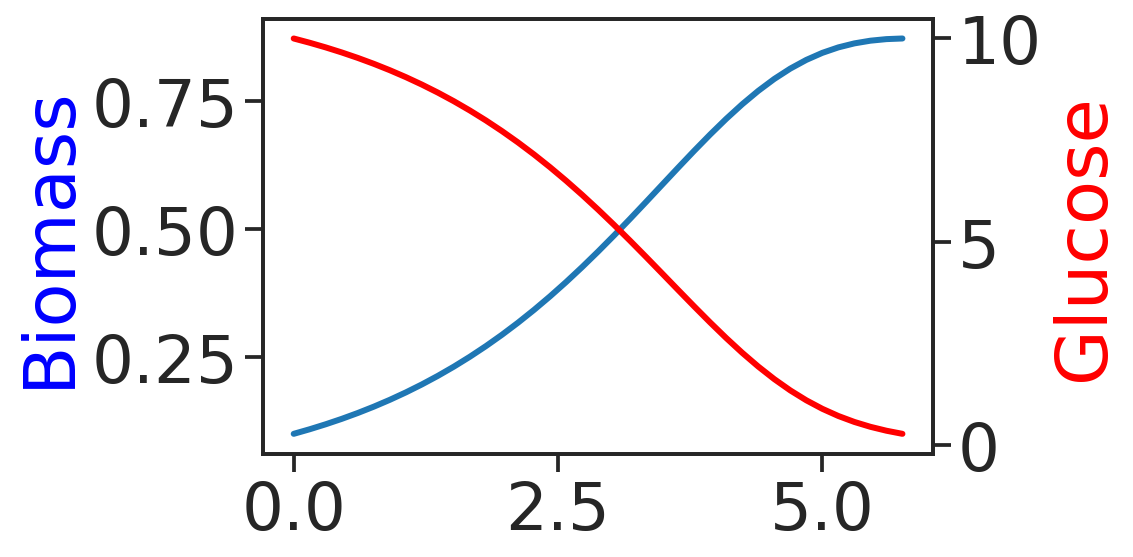

In [ ]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')